# Fashion MNIST (grayscale)

https://github.com/zalandoresearch/fashion-mnist

### 1. 데이터 로드

In [1]:
from torchvision import datasets

train_dataset = datasets.FashionMNIST(root='./', train=True, download=True)
test_dataset = datasets.FashionMNIST(root='./', train=False, download=True)

100%|██████████| 26.4M/26.4M [00:02<00:00, 9.67MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 177kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 2.92MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 9.75MB/s]


In [2]:
train_dataset, test_dataset

(Dataset FashionMNIST
     Number of datapoints: 60000
     Root location: ./
     Split: Train,
 Dataset FashionMNIST
     Number of datapoints: 10000
     Root location: ./
     Split: Test)

In [4]:
print(train_dataset[0])
print(train_dataset.data[0])

(<PIL.Image.Image image mode=L size=28x28 at 0x79F5A91C94F0>, 9)
tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   1,   0,
           0,  13,  73,   0,   0,   1,   4,   0,   0,   0,   0,   1,   1,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,   0,
          36, 136, 127,  62,  54,   0,   0,   0,   1,   3,   4,   0,   0,   3],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   6,   0,
         102, 204, 176, 134, 144, 123,  23,   0,   0,   0,   

In [8]:
print(train_dataset.data.shape)

# 전처리 (채널차원 추가 및 정규화)
train_images = train_dataset.data.unsqueeze(1) / 255.0  # 0~1
train_images = (train_images - 0.5) / 0.5               # -1~1
train_labels = train_dataset.targets.long()

test_images = test_dataset.data.unsqueeze(1) / 255.0
test_images = (test_images - 0.5) / 0.5
test_labels = test_dataset.targets.long()

torch.Size([60000, 28, 28])


In [9]:
# 학습/검증 데이터셋 분할
from sklearn.model_selection import train_test_split

train_idx, val_idx = train_test_split(range(len(train_images)), test_size=0.15, random_state=42)

tr_images = train_images[train_idx]
tr_labels = train_labels[train_idx]
val_images = train_images[val_idx]
val_labels = train_labels[val_idx]

- 데이터 시각화

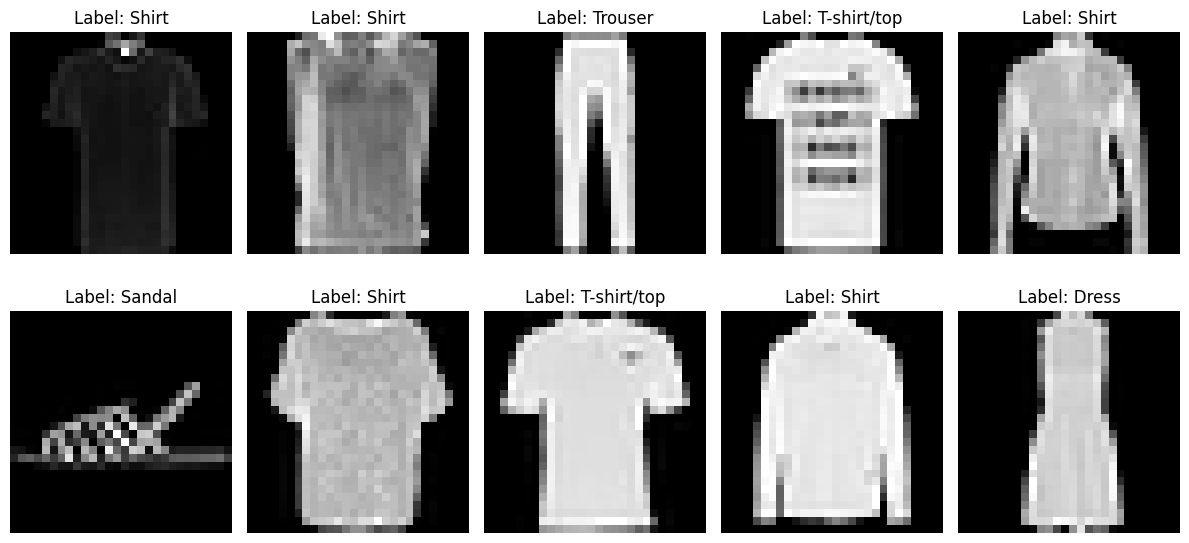

In [11]:
import numpy as np
import matplotlib.pyplot as plt

random_idx = np.random.choice(len(tr_images), 10, replace=False)
random_images = tr_images[random_idx]
random_labels = tr_labels[random_idx]

class_name = train_dataset.classes

plt.figure(figsize=(12, 6))
for i in range(10):
  plt.subplot(2, 5, i+1)

  img = random_images[i].squeeze()
  plt.imshow(img, cmap='gray')
  plt.title(f"Label: {class_name[random_labels[i]]}")
  plt.axis('off')

plt.tight_layout()
plt.show()

### 2. 모델 생성

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class FashionMNISTCNN(nn.Module):
  def __init__(self):
    super().__init__()

    self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding="same")
    self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding="valid")
    self.pool = nn.MaxPool2d(2, 2)

    self.flatten = nn.Flatten()
    self.dropout1 = nn.Dropout(0.3)
    self.fc1 = nn.Linear(64 * 13 * 13, 100)
    self.dropout2 = nn.Dropout(0.2)
    self.fc2 = nn.Linear(100, 10)

  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = F.relu(self.conv2(x))
    x = self.pool(x)

    x = self.flatten(x)
    x = self.dropout1(x)
    x = F.relu(self.fc1(x))
    x = self.dropout2(x)
    return self.fc2(x)

model = FashionMNISTCNN()
model

FashionMNISTCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=valid)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (dropout1): Dropout(p=0.3, inplace=False)
  (fc1): Linear(in_features=10816, out_features=100, bias=True)
  (dropout2): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=100, out_features=10, bias=True)
)

In [15]:
from torchsummary import summary

summary(model, (1, 28, 28), device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
            Conv2d-2           [-1, 64, 26, 26]          18,496
         MaxPool2d-3           [-1, 64, 13, 13]               0
           Flatten-4                [-1, 10816]               0
           Dropout-5                [-1, 10816]               0
            Linear-6                  [-1, 100]       1,081,700
           Dropout-7                  [-1, 100]               0
            Linear-8                   [-1, 10]           1,010
Total params: 1,101,526
Trainable params: 1,101,526
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.77
Params size (MB): 4.20
Estimated Total Size (MB): 4.98
----------------------------------------------------------------


### 3. 모델 학습

In [16]:
from torch.utils.data import TensorDataset, DataLoader

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

batch_size = 128
train_dataset = TensorDataset(tr_images, tr_labels)
val_dataset = TensorDataset(val_images, val_labels)
test_dataset = TensorDataset(test_images, test_labels)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [17]:
history = {
    "train_loss": [],
    "train_acc": [],
    "val_loss": [],
    "val_acc": []
}

epochs = 30
for epoch in range(epochs):
  model.train()
  train_loss = 0.0
  train_total = 0
  train_correct = 0

  for batch_idx, (images, labels) in enumerate(train_loader):
    images, labels = images.to(device), labels.to(device)

    optimizer.zero_grad()
    outputs = model(images)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    train_loss += loss.detach().cpu().item()
    _, pred = torch.max(outputs.data, 1)
    train_total += labels.size(0)
    train_correct += (pred == labels).sum().detach().cpu().item()

  model.eval()
  val_loss = 0.0
  val_total = 0
  val_correct = 0

  with torch.no_grad():
    for batch_idx, (images, labels) in enumerate(val_loader):
      images, labels = images.to(device), labels.to(device)
      outputs = model(images)
      loss = criterion(outputs, labels)

      val_loss += loss.detach().cpu().item()
      _, pred = torch.max(outputs.data, 1)
      val_total += labels.size(0)
      val_correct += (pred == labels).sum().detach().cpu().item()

  train_loss /= len(train_loader)
  val_loss /= len(val_loader)
  train_acc = train_correct / train_total
  val_acc = val_correct / val_total

  history["train_loss"].append(train_loss)
  history["train_acc"].append(train_acc)
  history["val_loss"].append(val_loss)
  history["val_acc"].append(val_acc)

  if (epoch + 1) % 5 == 0:
    print(f"Epoch [{epoch + 1}/{epochs}] {train_acc=:.4f} {train_loss=:.4f} {val_acc=:.4f} {val_loss=:.4f}")

Epoch [5/30] train_acc=0.9301 train_loss=0.1902 val_acc=0.9196 val_loss=0.2259
Epoch [10/30] train_acc=0.9598 train_loss=0.1065 val_acc=0.9280 val_loss=0.2283
Epoch [15/30] train_acc=0.9747 train_loss=0.0671 val_acc=0.9284 val_loss=0.2467
Epoch [20/30] train_acc=0.9819 train_loss=0.0490 val_acc=0.9251 val_loss=0.3038
Epoch [25/30] train_acc=0.9857 train_loss=0.0382 val_acc=0.9299 val_loss=0.3476
Epoch [30/30] train_acc=0.9867 train_loss=0.0360 val_acc=0.9302 val_loss=0.3316


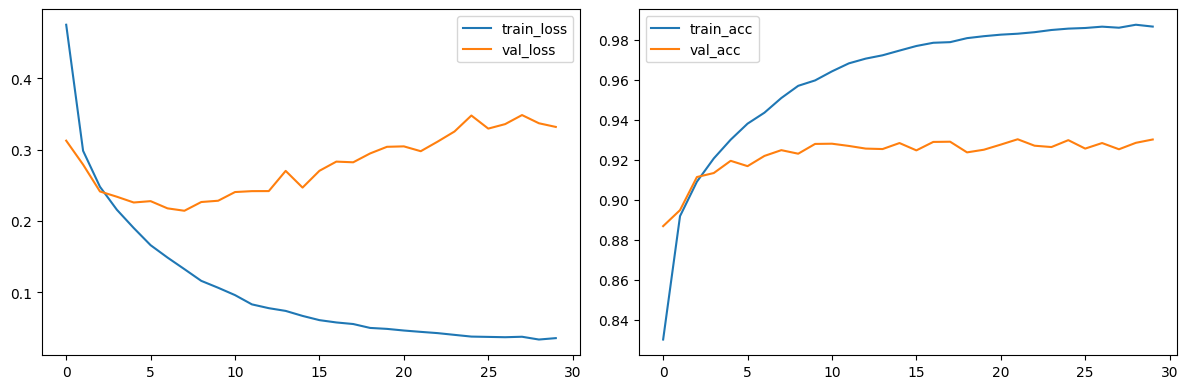

In [18]:
# 학습 시각화
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history["train_loss"], label="train_loss")
plt.plot(history["val_loss"], label="val_loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history["train_acc"], label="train_acc")
plt.plot(history["val_acc"], label="val_acc")
plt.legend()

plt.tight_layout()
plt.show()

### 4. 모델 평가

In [19]:
model.eval()
test_loss = 0.0
test_total = 0
test_correct = 0

with torch.no_grad():
  for batch_idx, (images, labels) in enumerate(test_loader):
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    loss = criterion(outputs, labels)

    test_loss += loss.detach().cpu().item()
    _, pred = torch.max(outputs.data, 1)
    test_total += labels.size(0)
    test_correct += (pred == labels).sum().detach().cpu().item()

test_loss /= len(test_loader)
test_acc = test_correct / test_total

print(f"Test 결과: {test_acc=:.4f} {test_loss=:.4f}")

Test 결과: test_acc=0.9266 test_loss=0.3787


### 5. 특성맵 시각화

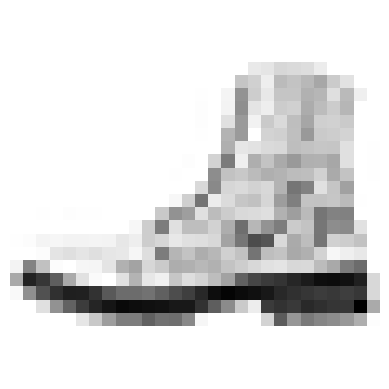

In [21]:
sample_image = tr_images[1].squeeze()
plt.imshow(sample_image, cmap="gray_r")
plt.axis("off")
plt.show()

In [22]:
class FeatureExtractor:
  def __init__(self, model, layer_name):
    self.model = model
    self.layer_name = layer_name
    self.features = None

    layer = dict(model.named_modules())[layer_name]
    layer.register_forward_hook(self.hook)

  def hook(self, module, input, output):
    self.features = output

  def get_features(self, x):
    self.model.eval()
    with torch.no_grad():
      _ = self.model(x)
    return self.features

torch.Size([1, 32, 28, 28])


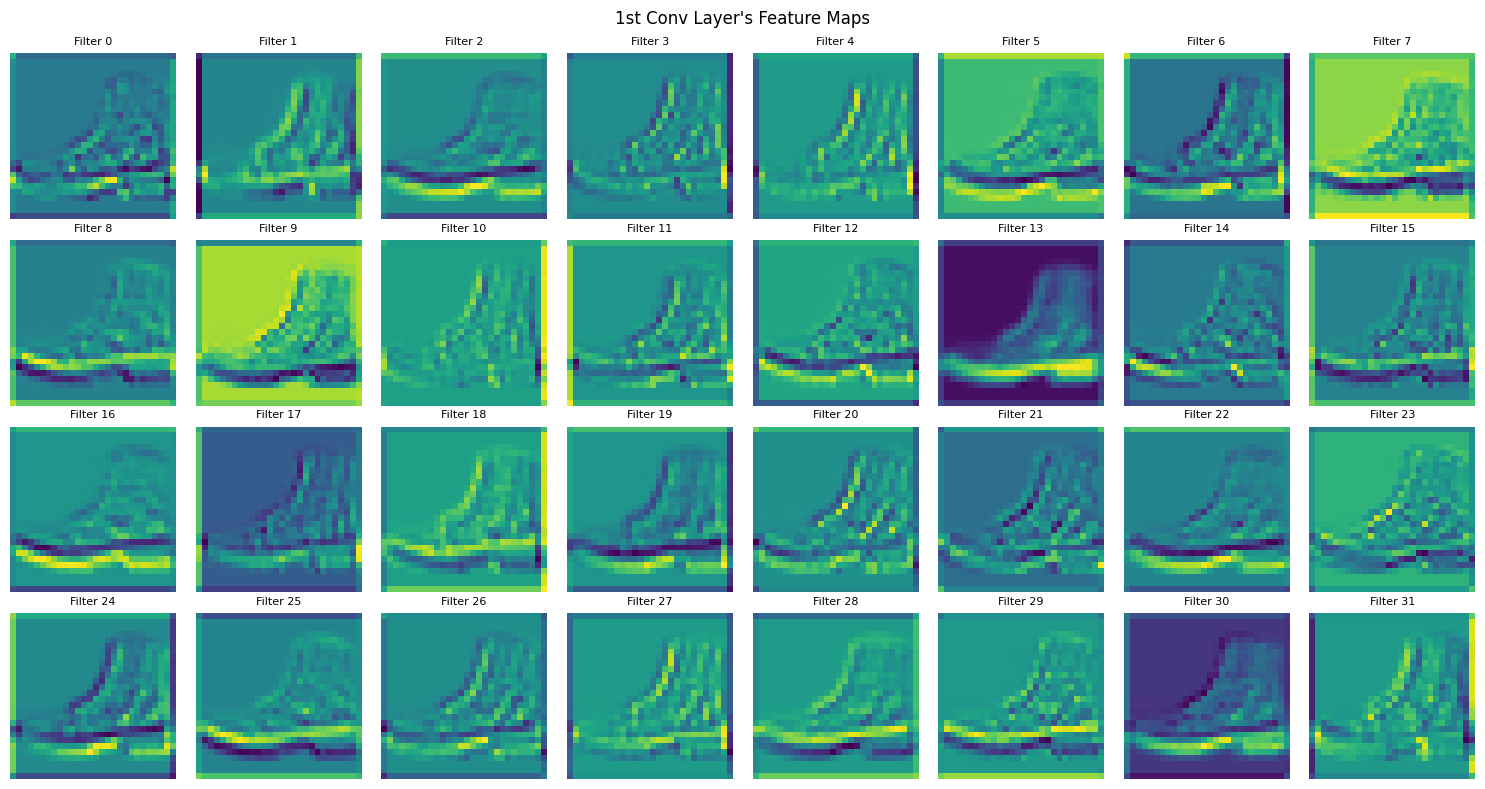

In [24]:
inputs = tr_images[1:2].to(device)

conv1_extractor = FeatureExtractor(model, "conv1")
feature_maps = conv1_extractor.get_features(inputs)
print(feature_maps.shape)

feature_maps_np = feature_maps.cpu().numpy()

fig, axs = plt.subplots(4, 8, figsize=(15, 8))

for i in range(4):
  for j in range(8):
    axs[i, j].imshow(feature_maps_np[0, i * 8 + j, :, :], cmap="viridis")
    axs[i, j].axis("off")
    axs[i, j].set_title(f"Filter {i * 8 + j}", fontsize=8)

plt.suptitle("1st Conv Layer's Feature Maps")
plt.tight_layout()
plt.show()

torch.Size([1, 64, 26, 26])


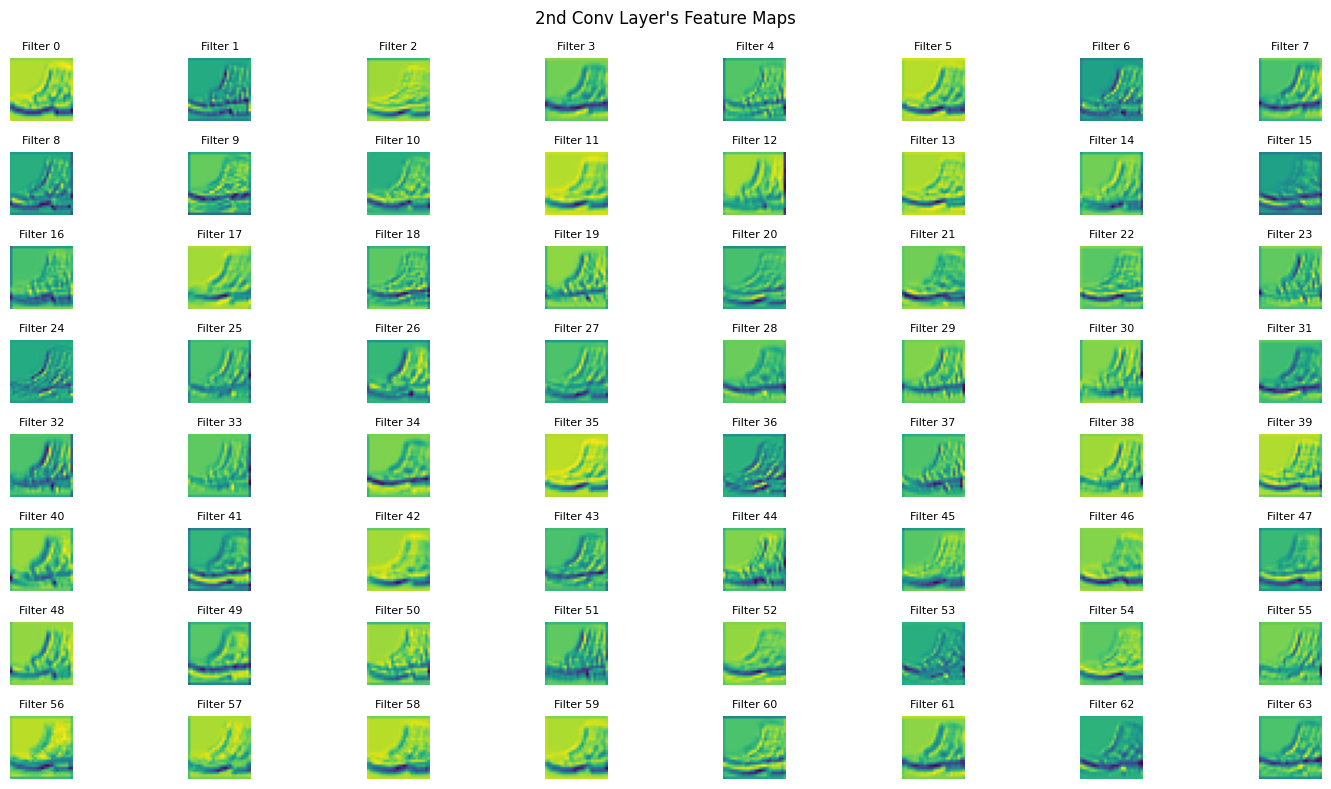

In [26]:
inputs = tr_images[1:2].to(device)

conv2_extractor = FeatureExtractor(model, "conv2")
feature_maps = conv2_extractor.get_features(inputs)
print(feature_maps.shape)

feature_maps_np = feature_maps.cpu().numpy()

fig, axs = plt.subplots(8, 8, figsize=(15, 8))

for i in range(8):
  for j in range(8):
    axs[i, j].imshow(feature_maps_np[0, i * 8 + j, :, :], cmap="viridis")
    axs[i, j].axis("off")
    axs[i, j].set_title(f"Filter {i * 8 + j}", fontsize=8)

plt.suptitle("2nd Conv Layer's Feature Maps")
plt.tight_layout()
plt.show()